# Libraries

In [1]:
! pip install transformers
! pip install hazm
from hazm import *
import transformers
from transformers import AdamW
from transformers.optimization import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import json
from copy import deepcopy
import numpy as np
import random
import re
import string
import codecs
from shutil import copyfile
random.seed(12345)
label_encoder = preprocessing.LabelEncoder()

# Loading & Preprocessing data

In [2]:
# downloading data
! gdown --id 1-RsTl3O4wAuFwEhWf6CeYvEVVVt7KOhg
! gdown --id 1-Eqj4sxyHycBBmRKWmI4wbF8JERUZfbS
! gdown --id 1-LZ-SDK6QmnqH5OfhtZ_rotYg8I0aW0R
# downloading persian stopwords
! gdown --id 1Qiq2I8EdTcgn2Wc03XqucUcMhBdVhEre

Downloading...
From: https://drive.google.com/uc?id=1-RsTl3O4wAuFwEhWf6CeYvEVVVt7KOhg
To: /content/train.json
100% 236M/236M [00:01<00:00, 159MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-Eqj4sxyHycBBmRKWmI4wbF8JERUZfbS
To: /content/eval.json
100% 23.3M/23.3M [00:00<00:00, 142MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1-LZ-SDK6QmnqH5OfhtZ_rotYg8I0aW0R
To: /content/test.json
100% 23.6M/23.6M [00:00<00:00, 143MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Qiq2I8EdTcgn2Wc03XqucUcMhBdVhEre
To: /content/stopwords.txt
100% 3.66k/3.66k [00:00<00:00, 3.08MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-LZ-SDK6QmnqH5OfhtZ_rotYg8I0aW0R
To: /content/test.json
100% 23.6M/23.6M [00:00<00:00, 207MB/s]


In [3]:
# loading raw train and val data
with open('train.json') as f_train:
  raw_train_data = json.load(f_train)

with open('eval.json') as f_eval:
  raw_eval_data = json.load(f_eval)

with open('test.json') as f_test:
  raw_test_data = json.load(f_test)

In [4]:
class Preprocessing:

  @staticmethod
  def remove_punctuations(text):
    new_text = []
    for l in text:
      if l not in string.punctuation + '\u00AB' + '\u00BB' + '\u060C' + '\u061B' + '\u061F':
        new_text.append(l)
      else:
        new_text.append(' ')
    return ''.join(new_text)
  
  @staticmethod
  def remove_numbers(text):
    new_text = []
    for l in text:
      if l not in '0123456789۰۱۲۳۴۵۶۷۸۹':
        new_text.append(l)
      else:
        new_text.append(' ')
    return ''.join(new_text)

  @staticmethod
  def remove_stopwords(text):
    normalizer = Normalizer()
    stopwords = [normalizer.normalize(x.strip()) for x in codecs.open('stopwords.txt','r','utf-8').readlines()]
    tokens = word_tokenize(text)
    new_text = []
    for token in tokens:
      if token not in stopwords:
        new_text.append(token)
      else:
        new_text.append(' ')
    return ' '.join(new_text)

  @staticmethod
  def remove_extra_space(text):
    new_text = re.sub(r'\s+',' ',text)
    return new_text

In [5]:
# a class to hold our data structure
class Data:

  def __init__(self, data, preprocessing=False):
    self.abstract = data['abstract']
    self.title = data['title']
    self.text = data['text']
    self.category = data['category']
    self.label = label_encoder.transform([self.category])[0]

# label encoder
all_labels = [data['category'] for data in raw_train_data]
label_encoder.fit(all_labels)
classes = label_encoder.classes_

# convert raw data into Data objects
train_data = []
for data in tqdm(raw_train_data):
  train_data.append(Data(data, True))

eval_data = []
for data in tqdm(raw_eval_data):
  eval_data.append(Data(data, True))

test_data = []
for data in tqdm(raw_test_data):
  test_data.append(Data(data, True))

100%|██████████| 2000/2000 [00:00<00:00, 28997.63it/s]


In [6]:
# a function to get a portion of data with acquired preprocessings
def get_data(train_data, eval_data, test_data, sample_size, preproces={
    'remove_stopwords': True,
    'remove_punctuations': True,
    'remove_numbers': True}):
  random.seed(12345)
  random.shuffle(train_data)
  random.shuffle(eval_data)
  train_data = train_data[:int(sample_size * len(train_data))]

  # applying preprocessings on train data
  for i, data in enumerate(tqdm(train_data)):
    if preproces['remove_stopwords'] == True:
      train_data[i].text = Preprocessing.remove_stopwords(data.text)
    if preproces['remove_punctuations'] == True:
      train_data[i].text = Preprocessing.remove_punctuations(data.text)
    if preproces['remove_numbers'] == True:
      train_data[i].text = Preprocessing.remove_numbers(data.text)
    train_data[i].text = Preprocessing.remove_extra_space(data.text)

  # applying preprocessings on eval data
  for i, data in enumerate(tqdm(eval_data)):
    if preproces['remove_stopwords'] == True:
      eval_data[i].text = Preprocessing.remove_stopwords(data.text)
    if preproces['remove_punctuations'] == True:
      eval_data[i].text = Preprocessing.remove_punctuations(data.text)
    if preproces['remove_numbers'] == True:
      eval_data[i].text = Preprocessing.remove_numbers(data.text)
    eval_data[i].text = Preprocessing.remove_extra_space(data.text)

  # applying preprocessings on test data
  for i, data in enumerate(tqdm(test_data)):
    if preproces['remove_stopwords'] == True:
      test_data[i].text = Preprocessing.remove_stopwords(data.text)
    if preproces['remove_punctuations'] == True:
      test_data[i].text = Preprocessing.remove_punctuations(data.text)
    if preproces['remove_numbers'] == True:
      test_data[i].text = Preprocessing.remove_numbers(data.text)
    test_data[i].text = Preprocessing.remove_extra_space(data.text)

  return train_data, eval_data, test_data

# Logistic regression (Method 1)

## Preparing Data for TF-IDF

In [7]:
lr_train_data, lr_eval_data, lr_test_data = get_data(train_data, eval_data, test_data, sample_size=1, preproces={
    'remove_stopwords': False,
    'remove_punctuations': False,
    'remove_numbers': False})

100%|██████████| 2000/2000 [00:00<00:00, 6751.66it/s]


In [8]:
title = []
abstract = []
text = []
category = []
for i in range(len(lr_train_data)):
    title.append(lr_train_data[i].title)
    abstract.append(lr_train_data[i].abstract)
    text.append(lr_train_data[i].text)
    category.append(lr_train_data[i].category)

zippedList =  list(zip(title, abstract, text, category))
# Create a dataframe from zipped list
train = pd.DataFrame(zippedList, columns = ['title' , 'abstract', 'text', 'category'])
print(train.shape)
train.head(5)

(20000, 4)


,title,abstract,text,category
0,سرمربی فوتبال سیرجان: بازی با ملوان را آسان نم...,سرمربی تیم فوتبال بانوان شهرداری سیرجان گفت: م...,به گزارش خبرنگار ورزشی خبرگزاری فارس، تیم فوتب...,sports
1,ساخت آنتی بادی؛ درمان بعدی برای ویروس کرونا,با توجه به اینکه دنیا در انتظار واکسن کووید 19...,به گزارش خبرنگار گروه علمی و دانشگاهی خبرگزاری...,scientific-academic
2,الاخبار| تلاش آمریکا برای تغییر مأموریت «یونیف...,یک روزنامه لبنانی اعلام کرد، آمریکا در حال ان...,به گزارش گروه بین‌الملل خبرگزاری فارس، روزنامه...,world
3,برنامه ریزی جهت اتصال خطوط مترو به مراکز بیمار...,رئیس سازمان پیشگیری و مدیریت بحران شهر تهران ب...,به گزارش گروه شهری خبرگزاری فارس، رضا کرمی محم...,social
4,اقدامات دولت‌ها به منظور حمایت از مستاجران در ...,مرکز پژوهش‌های مجلس با تاکید بر اینکه مداخله ...,به گزارش خبرگزاری فارس، مرکز پژوهش‌های مجلس شو...,economy


In [9]:
title = []
abstract = []
text = []
category = []
for i in range(len(lr_eval_data)):
    title.append(lr_eval_data[i].title)
    abstract.append(lr_eval_data[i].abstract)
    text.append(lr_eval_data[i].text)
    category.append(lr_eval_data[i].category)

zippedList =  list(zip(title, abstract, text, category))
# Create a dataframe from zipped list
val = pd.DataFrame(zippedList, columns = ['title' , 'abstract', 'text', 'category'])
print(val.shape)
val.head(5)

(2000, 4)


,title,abstract,text,category
0,رئیس جدید شورای هوا‌فضا در جامعه همسود انتخاب شد,وزیر توسعه دیجیتال، نوآوری و صنایع هوافضا قزاق...,به گزارش خبرنگار خبرگزاری فارس در دوشنبه، «بغد...,regional-offices
1,واکنش مدیرعامل چادرملو به پرداخت پول به ویلموت...,مدیرعامل شرکت چادرملو ارتباط مالی با فدراسیون ...,به گزارش خبرنگار ورزشی خبرگزاری فارس، ماجرای پ...,sports
2,فاش شدن روابط غیراخلاقی مدیر ارشد مک دونالد 9 ...,شرکت مک دونالد 9 ماه پس از اینکه که مدیر ارشد ...,به گزارش گروه اقتصاد بین الملل فارس به نقل از ...,economy
3,ساندرو: در بازی برگشت یوونتوس باید بهتر باشد,مدافع برزیلی و با تجربه یوونتوس خواستار جبران ...,به گزارش خبرگزاری فارس، شب گذشته یوونتوس گام ن...,sports
4,تاکید مقیمی بر سرعت فرآیند تجدید ارزیابی دارای...,مدیرعامل گروه صنعتی ایران خودرو در بازدید از خ...,اخبار شرکت‌ها- فرشاد مقیمی، در نشستی با مدیران...,economy


In [10]:
# label encoding on labels in 'category'
from sklearn.preprocessing import LabelEncoder

train.category= LabelEncoder().fit_transform(train.category.values)
val.category= LabelEncoder().fit_transform(val.category.values)
val.head(5)

,title,abstract,text,category
0,رئیس جدید شورای هوا‌فضا در جامعه همسود انتخاب شد,وزیر توسعه دیجیتال، نوآوری و صنایع هوافضا قزاق...,به گزارش خبرنگار خبرگزاری فارس در دوشنبه، «بغد...,4
1,واکنش مدیرعامل چادرملو به پرداخت پول به ویلموت...,مدیرعامل شرکت چادرملو ارتباط مالی با فدراسیون ...,به گزارش خبرنگار ورزشی خبرگزاری فارس، ماجرای پ...,7
2,فاش شدن روابط غیراخلاقی مدیر ارشد مک دونالد 9 ...,شرکت مک دونالد 9 ماه پس از اینکه که مدیر ارشد ...,به گزارش گروه اقتصاد بین الملل فارس به نقل از ...,2
3,ساندرو: در بازی برگشت یوونتوس باید بهتر باشد,مدافع برزیلی و با تجربه یوونتوس خواستار جبران ...,به گزارش خبرگزاری فارس، شب گذشته یوونتوس گام ن...,7
4,تاکید مقیمی بر سرعت فرآیند تجدید ارزیابی دارای...,مدیرعامل گروه صنعتی ایران خودرو در بازدید از خ...,اخبار شرکت‌ها- فرشاد مقیمی، در نشستی با مدیران...,2


## BOW

In [11]:
# Bag-of-Words vectorization 
from sklearn.feature_extraction.text import CountVectorizer


def count_vect(data, ngrams=(1, 2)):
    count_vectorizer = CountVectorizer(ngram_range=ngrams)
    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

In [12]:
train_counts, count_vectorizer = count_vect(train["text"])
val_counts = count_vectorizer.transform(val["text"])

## Tf-Idf

In [11]:
# tf-idf vectorization
from sklearn.feature_extraction.text import TfidfVectorizer


def tfidf(data, ngrams=(1, 2)):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngrams)
    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

In [12]:
train_tfidf, tfidf_vectorizer = tfidf(train["text"])
val_tfidf = tfidf_vectorizer.transform(val["text"])

## Training Models (TF-IDF)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

In [16]:
# train val split
X_train_counts = train_counts
y_train_counts = train["category"].values

X_val_counts = val_counts
y_val_counts = val["category"].values


In [14]:
# classes count values
train["category"].value_counts()

7    5017
8    3369
2    2512
3    2487
6    2463
1    1663
0     839
5     828
4     822
Name: category, dtype: int64

In [15]:
X_train_tfidf = train_tfidf
y_train_tfidf = train["category"].values

X_val_tfidf = val_tfidf
y_val_tfidf = val["category"].values

In [16]:
model_tfidf = LogisticRegression()
model_tfidf.fit(X_train_tfidf, y_train_tfidf)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [17]:
# evaluation on validation data [tf-idf]
y_pred_tfidf = model_tfidf.predict(X_val_tfidf)

acc_tf = accuracy_score(y_val_tfidf, y_pred_tfidf)
macro_f1_tf  = f1_score(y_val_tfidf, y_pred_tfidf, average='macro')
micro_f1_tf  = f1_score(y_val_tfidf, y_pred_tfidf, average='micro')
print(f"Logestic regression TF-IDF macro f1-Score: {macro_f1_tf}")
print(f"Logestic regression TF-IDF micro f1-Score: {micro_f1_tf}")
print(f"Logestic regression TF-IDF acc-Score: {acc_tf}")

Logestic regression TF-IDF macro f1-Score: 0.9246261231419501
Logestic regression TF-IDF micro f1-Score: 0.9375
Logestic regression TF-IDF acc-Score: 0.9375


## Test Data Prepration

In [22]:
test = pd.read_json('/content/test.json')
test.to_csv(index=False, sep='\t', encoding="utf-8")
print(test.shape)
test.head(5)

(2000, 4)


,title,abstract,text,category
0,ترتیل صفحه ۴۹۷ قرآن کریم+فیلم و متن آیات,امام علی (ع) می‌فرمایند: بدانید که این قرآن پن...,خبرگزاری فارس- گروه قرآن و فعالیت‌های دینی: ام...,culture
1,رئیس سابق پارلمان عراق: سخن از ایجاد اقلیم سنی...,رئیس سابق پارلمان عراق با اشاره به اینکه سیاست...,به گزارش گروه بین‌الملل خبرگزاری فارس، «سلیم ا...,world
2,«عارف» دهه هشتادی چگونه آسمانی شد+عکس,پدرش می گوید خیلی مهربان بود. با همه می‌جوشید....,گروه جامعه خبرگزاری فارس - سکوت ویژگی جدا نشدن...,social
3,سخنگوی دولت: مدیریت اقتصادی دولت موجب شکست تحر...,علی ربیعی گفت: مدیریت اقتصادی و سیاسی دولت بود...,به گزارش خبرنگار حوزه دولت خبرگزاری فارس، علی ...,politics
4,نماینده عراقی: نحوه تعامل دولت الکاظمی با تواف...,یک نماینده پارلمان عراق نحوه تعامل دولت مصطفی ...,به گزارش گروه بین‌الملل خبرگزاری فارس، «احمد ا...,world


In [23]:
from sklearn.preprocessing import LabelEncoder

test.category= LabelEncoder().fit_transform(test.category.values)

test.head(5)

,title,abstract,text,category
0,ترتیل صفحه ۴۹۷ قرآن کریم+فیلم و متن آیات,امام علی (ع) می‌فرمایند: بدانید که این قرآن پن...,خبرگزاری فارس- گروه قرآن و فعالیت‌های دینی: ام...,1
1,رئیس سابق پارلمان عراق: سخن از ایجاد اقلیم سنی...,رئیس سابق پارلمان عراق با اشاره به اینکه سیاست...,به گزارش گروه بین‌الملل خبرگزاری فارس، «سلیم ا...,8
2,«عارف» دهه هشتادی چگونه آسمانی شد+عکس,پدرش می گوید خیلی مهربان بود. با همه می‌جوشید....,گروه جامعه خبرگزاری فارس - سکوت ویژگی جدا نشدن...,6
3,سخنگوی دولت: مدیریت اقتصادی دولت موجب شکست تحر...,علی ربیعی گفت: مدیریت اقتصادی و سیاسی دولت بود...,به گزارش خبرنگار حوزه دولت خبرگزاری فارس، علی ...,3
4,نماینده عراقی: نحوه تعامل دولت الکاظمی با تواف...,یک نماینده پارلمان عراق نحوه تعامل دولت مصطفی ...,به گزارش گروه بین‌الملل خبرگزاری فارس، «احمد ا...,8


In [26]:
X_test_tf_idf = tfidf_vectorizer.transform(test["text"])
y_test_tf_idf = test["category"].values

## TF-IDF Test

In [28]:
y_pred_test_tf_idf = model_tfidf.predict(X_test_tf_idf)
f1_macro = f1_score(y_test_tf_idf, y_pred_test_tf_idf, average='macro')
f1_micro = f1_score(y_test_tf_idf, y_pred_test_tf_idf, average='micro')
accuracy = accuracy_score(y_test_tf_idf, y_pred_test_tf_idf)
print(f'F1-macro {f1_macro}')
print(f'F1-micro {f1_micro}')
print(f'Accuracy {accuracy}')

F1-macro 0.9197576405533964
F1-micro 0.9375
Accuracy 0.9375


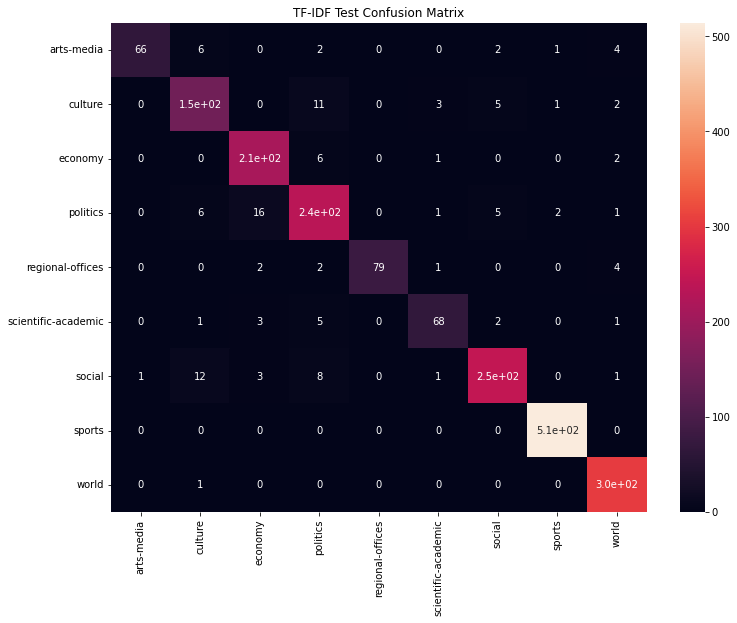

In [29]:
c_mat = confusion_matrix(y_test_tf_idf, y_pred_test_tf_idf)
df_cm = pd.DataFrame(c_mat, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (12,9))
plt.title('TF-IDF Test Confusion Matrix')
sn.heatmap(df_cm, annot=True)

## Extract Keywords

In [30]:
def correct(A):
    b = [a for a in A]
    return list(reversed(b))

In [31]:
important_words_idx = [[],[],[],[],[],[],[],[],[]]
important_words = [[],[],[],[],[],[],[],[],[]]
for i in range(len(classes)):
  important_words_idx[i] = np.argpartition(model_tfidf.coef_[i], -40)[-40:]
  important_words_idx[i] = important_words_idx[i][np.argsort(model_tfidf.coef_[i][important_words_idx[i]])]
  important_words[i] = correct(zip(tfidf_vectorizer.get_feature_names_out()[important_words_idx[i]],np.around(model_tfidf.coef_[i][important_words_idx[i]],decimals=3)))

In [32]:
lr_keywords = {}

for i, opt in enumerate(classes):
     lr_keywords[opt] = important_words[i]

lr_keywords = pd.DataFrame(lr_keywords) 
lr_keywords

,arts-media,culture,economy,politics,regional-offices,scientific-academic,social,sports,world
0,"(فیلم, 6.635)","(کتاب, 7.991)","(اقتصادی, 5.184)","(مجلس, 8.071)","(افغانستان, 6.439)","(گروه علمی, 6.194)","(تهران, 6.206)","(تیم, 9.338)","(گروه بین, 7.19)"
1,"(تئاتر, 4.467)","(قرآن, 5.534)","(خبرنگار اقتصادی, 5.177)","(اسلامی, 5.204)","(تاجیکستان, 5.634)","(علمی دانشگاهی, 6.109)","(سلامت, 5.061)","(فدراسیون, 7.989)","(الملل خبرگزاری, 6.016)"
2,"(رسانه, 4.464)","(هیأت, 4.063)","(اقتصادی خبرگزاری, 5.139)","(مردم, 4.773)","(ازبکستان, 5.601)","(علمی, 6.037)","(شهری, 4.431)","(باشگاه, 7.898)","(آمریکا, 5.522)"
3,"(سریال, 4.173)","(مسجد, 3.675)","(بانک, 3.911)","(پارلمانی خبرگزاری, 4.664)","(قرقیزستان, 5.143)","(خبرنگار گروه, 5.583)","(سلامت خبرگزاری, 4.14)","(بازی, 6.762)","(بین الملل, 5.484)"
4,"(مستند, 3.449)","(حرم, 3.586)","(اقتصاد بین, 3.844)","(پارلمانی, 4.411)","(قزاقستان, 4.927)","(دانشگاهی خبرگزاری, 5.412)","(قضایی, 3.604)","(گزارش خبرگزاری, 5.874)","(الملل, 5.482)"
5,"(نمایش, 3.442)","(حج, 3.366)","(اقتصاد, 3.702)","(خبرنگار پارلمانی, 4.175)","(خبرنگار خبرگزاری, 4.844)","(دانشگاهی, 5.407)","(شهرداری, 3.561)","(لیگ, 5.283)","(گزارش گروه, 5.388)"
6,"(موسیقی, 3.323)","(ادبیات, 2.766)","(شرکت, 3.631)","(مجلس شورای, 3.747)","(ترکمنستان, 3.961)","(دانشگاه, 5.116)","(شهری خبرگزاری, 3.544)","(فوتبال, 5.093)","(گروه, 4.092)"
7,"(سینمایی, 3.266)","(امام, 2.739)","(قیمت, 3.403)","(دولت, 3.633)","(پاکستان, 3.406)","(فناوری, 4.678)","(شهر تهران, 3.478)","(مسابقات, 4.321)","(بین, 3.996)"
8,"(هنری, 3.264)","(دینی, 2.686)","(نفت, 3.195)","(شورای اسلامی, 3.624)","(این کشور, 3.143)","(فارس به, 3.159)","(آموزش, 3.053)","(ورزشی, 4.255)","(عراق, 3.943)"
9,"(رادیو, 3.149)","(های دینی, 2.594)","(تولید, 3.058)","(روحانی, 3.51)","(فارس در, 3.103)","(نقل از, 2.953)","(پلیس, 3.028)","(بازیکن, 4.02)","(سعودی, 3.436)"


# Neural Networks (Method 2)

In [ ]:
nn_train_data, nn_test_data, nn_test_data = get_data(train_data, eval_data, test_data, sample_size=0.7, preproces={
    'remove_stopwords': True,
    'remove_punctuations': True,
    'remove_numbers': True})

100%|██████████| 2000/2000 [00:25<00:00, 77.28it/s]


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense,Conv1D,MaxPooling1D
from keras.layers import LSTM,Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint
import json
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:

train_y = []
train_X = []
test_y = []
test_X = []

for j,news in enumerate(nn_train_data):
    train_y.append(news.label)
    train_X.append(news.text)
train_y  = to_categorical(train_y, num_classes=None)   

###################################################
for j,news in enumerate(nn_test_data):
    test_y.append(news.label)
    test_X.append(news.text)
test_y  = to_categorical(test_y, num_classes=None)   
#############################################
vocab_selection = 10000
tokenizer = Tokenizer(num_words=vocab_selection,oov_token='N')
tokenizer.fit_on_texts(train_X)
pickle.dump(tokenizer, open('token_nn.pkl', 'wb'))
sequence_data_train = []
sequence_data_test = []
for abs_ in train_X:
    sequence_data_train.append(tokenizer.texts_to_sequences([abs_])[0])

for abs_ in test_X:
    sequence_data_test.append(tokenizer.texts_to_sequences([abs_])[0])

In [ ]:
sequence_data_train = tf.keras.preprocessing.sequence.pad_sequences(sequence_data_train, maxlen=4000, dtype='int32', padding='pre',truncating='pre', value=0.0)
sequence_data_test = tf.keras.preprocessing.sequence.pad_sequences(sequence_data_test, maxlen=4000, dtype='int32', padding='pre',truncating='pre', value=0.0)

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

MAX_LEN =4000
MAX_FEATURES = 10000
EMBED_SIZE = 128
RNN_CELL_SIZE = 128

class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
          
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
          
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights
    
sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)
lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences = True), name="bi_lstm_0")(embedded_sequences)

# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
context_vector, attention_weights = Attention(10)(lstm, state_h)
dense1 = Dense(256, activation="relu")(context_vector)
dropout = Dropout(0.05)(dense1)
output = Dense(9, activation="sigmoid")(dropout)
  
model = keras.Model(inputs=sequence_input, outputs=output)

In [ ]:
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 4000)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 4000, 128)    1280000     ['input_3[0][0]']                
                                                                                                  
 bi_lstm_0 (Bidirectional)      (None, 4000, 256)    263168      ['embedding_2[0][0]']            
                                                                                                  
 bi_lstm_1 (Bidirectional)      [(None, 4000, 256),  394240      ['bi_lstm_0[0][0]']              
                                 (None, 128),                                               

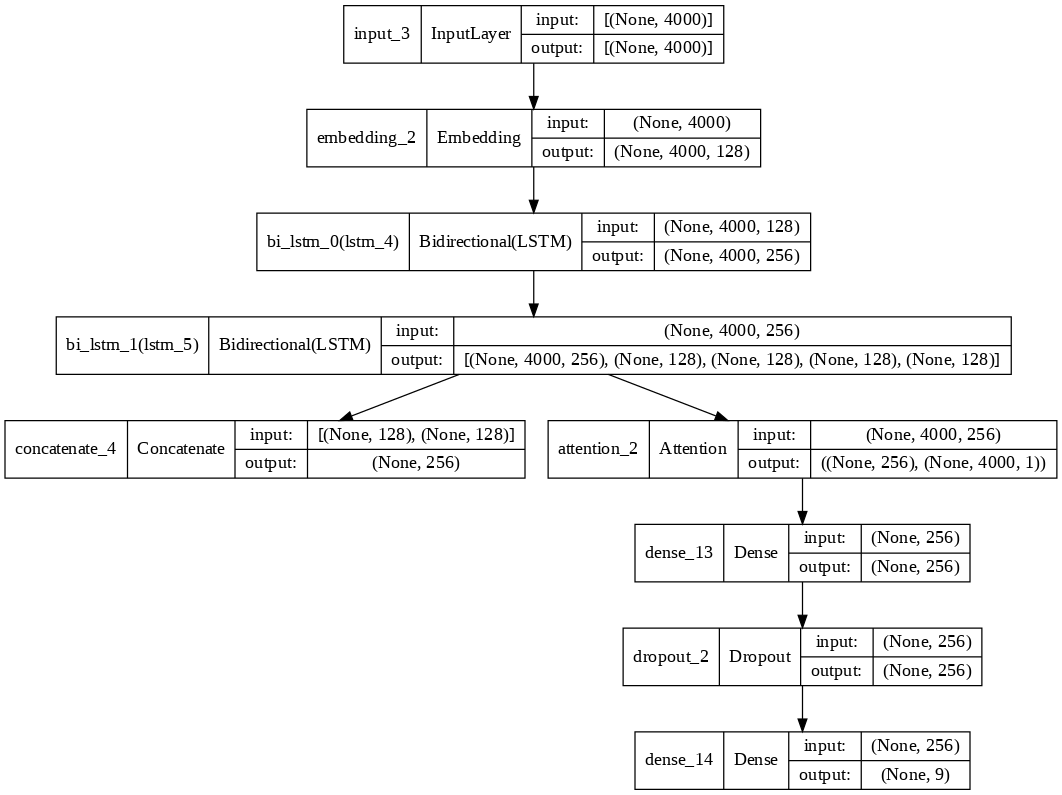

In [ ]:
keras.utils.plot_model(model, show_shapes=True, dpi=90)

In [ ]:
METRICS = [
    keras.metrics.BinaryAccuracy(name='accuracy')
]

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=METRICS)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
history = model.fit(sequence_data_train,train_y,batch_size=32,epochs=5,validation_split=0.2)

Epoch 1/5
350/350 [==============================] - 774s 2s/step - loss: 0.3072 - accuracy: 0.8977 - val_loss: 0.2246 - val_accuracy: 0.9240
Epoch 2/5
350/350 [==============================] - 767s 2s/step - loss: 0.1802 - accuracy: 0.9327 - val_loss: 0.1612 - val_accuracy: 0.9366
Epoch 3/5
350/350 [==============================] - 768s 2s/step - loss: 0.1297 - accuracy: 0.9441 - val_loss: 0.1161 - val_accuracy: 0.9546
Epoch 4/5
350/350 [==============================] - 768s 2s/step - loss: 0.0769 - accuracy: 0.9705 - val_loss: 0.0704 - val_accuracy: 0.9739
Epoch 5/5
350/350 [==============================] - 767s 2s/step - loss: 0.0474 - accuracy: 0.9837 - val_loss: 0.0639 - val_accuracy: 0.9778


In [ ]:
model.save_weights('model_weight.h5')

In [ ]:
model.load_weights("/content/drive/MyDrive/model_weight_lstm_atten.h5")

In [ ]:
result_predict = model.predict(sequence_data_test)

In [ ]:
all_pred = result_predict.argmax(axis =1)
test_y = test_y.argmax(axis =1)

In [ ]:
f1_macro = f1_score(all_pred, test_y, average='macro')
f1_micro = f1_score(all_pred, test_y, average='micro')
accuracy = accuracy_score(all_pred, test_y)
print(f'F1-macro {f1_macro}')
print(f'F1-micro {f1_micro}')
print(f'Accuracy {accuracy}')

F1-macro 0.8588882426114224
F1-micro 0.895
Accuracy 0.895


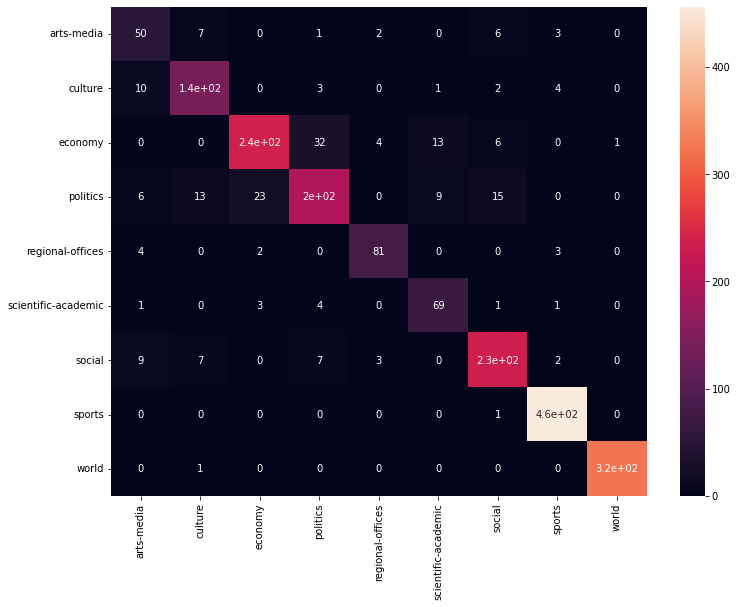

In [ ]:

c_mat = confusion_matrix(all_pred, test_y)
df_cm = pd.DataFrame(c_mat, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (12,9))
sn.heatmap(df_cm, annot=True)

# Transformer (Method 3)

## Loading Data for Transformer

In [ ]:
trans_train_data, trans_eval_data, trans_test_data = get_data(train_data, eval_data, test_data, sample_size=.5, preproces={
    'remove_stopwords': True,
    'remove_punctuations': True,
    'remove_numbers': True})

100%|██████████| 2000/2000 [00:29<00:00, 67.75it/s]


## Load Tokenizer and ParsBert

In [ ]:
# loading pars bert and tokenizer
from transformers import AutoConfig, AutoTokenizer, AutoModel, TFAutoModel
# v3.0
model_name_or_path = "HooshvareLab/bert-fa-zwnj-base"
config = AutoConfig.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
# model = TFAutoModel.from_pretrained(model_name_or_path)  For TF
parsbert = AutoModel.from_pretrained(model_name_or_path)

Some weights of the model checkpoint at HooshvareLab/bert-fa-zwnj-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at HooshvareLab/bert-fa-zwnj-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.poo

## Transformer Dataloader

In [ ]:
# a class for loading data
class NewsDataloader(Dataset):

  def __init__(self,dataset,tokenizer):
    self.dataset = dataset
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    text_tokens = self.tokenizer.encode_plus(
        self.dataset[idx].text,
        add_special_tokens=True,
        max_length=512,
        pad_to_max_length=True,
        return_tensors="pt",
        truncation=True
    )

    return [text_tokens, self.dataset[idx].label]

In [ ]:
# defining our transformer model
class TransformerModel(nn.Module):

  def __init__(self, bert):
    super(TransformerModel, self).__init__()
    self.bert = bert
    # we only use one linear head on the parsbert
    self.linear_head = nn.Linear(768, len(label_encoder.classes_))

  def forward(self, x):
    # main task
    x = self.bert(x['input_ids'],x['attention_mask'])
    logits = self.linear_head(x.pooler_output)
    return logits

## Training Transformer (Don't run this cell if you dont want the training)

In [ ]:
# Transformer Training
epochs = 2
lr = 2e-5
device = 'cuda:0'
k_step_loss = 0
k = 50
batch_size = 10
# get train dataloader
train_dataset = NewsDataloader(trans_train_data, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# get eval dataloader
eval_dataset = NewsDataloader(trans_eval_data, tokenizer)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True)
num_steps = int(np.ceil(len(train_dataloader.dataset) / batch_size))
loss_collection = []
eval_f1_micro = []
eval_f1_macro = []
eval_accuracy = []
model = TransformerModel(parsbert).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, 
    num_training_steps=epochs * len(train_dataloader.dataset)
)


for epoch in range(epochs):
  for step, data in enumerate(train_dataloader):
    input_ids = data[0]["input_ids"].squeeze().to(device)
    attention_mask = data[0]["attention_mask"].squeeze().to(device)
    labels = data[1].to(device)
    feed_dict = {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }

    optimizer.zero_grad()
    output = model(feed_dict)
    loss = loss_fn(output, labels)
    # loss scheduler
    loss_collection.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()
    k_step_loss += loss.item()
    if (step + 1) % k == 0:
      loss_collection.append(k_step_loss)
      print(f'EPOCH {epoch + 1}/{epochs} | STEP [{step + 1}/{num_steps}] | Loss {k_step_loss}')
      k_step_loss = 0
  
  k_step_loss = 0
  print(f'################## Epoch {epoch + 1} Evaluation ##################')
  with torch.no_grad():
    all_pred = []
    all_label = []
    for j, data in enumerate(eval_dataloader):
      input_ids = data[0]["input_ids"].squeeze().to(device)
      attention_mask = data[0]["attention_mask"].squeeze().to(device)
      labels = data[1].to(device)
      feed_dict = {
          'input_ids': input_ids,
          'attention_mask': attention_mask
      }
      output = model(feed_dict)
      pred = output.argmax(dim=1, keepdim=True)
      all_label.extend(list(labels.cpu().numpy()))
      all_pred.extend(list(pred.view(-1).cpu().numpy()))


    f1_macro = f1_score(all_label, all_pred, average='macro')
    f1_micro = f1_score(all_label, all_pred, average='micro')
    accuracy = accuracy_score(all_label, all_pred)
    print(f'F1-macro {f1_macro}')
    print(f'F1-micro {f1_micro}')
    print(f'Accuracy {accuracy}')
    eval_f1_macro.append(f1_macro)
    eval_f1_micro.append(f1_micro)
    eval_accuracy.append(accuracy)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


EPOCH 1/2 | STEP [50/1000] | Loss 71.13495004177094
EPOCH 1/2 | STEP [100/1000] | Loss 28.0577359944582
EPOCH 1/2 | STEP [150/1000] | Loss 10.310000263154507
EPOCH 1/2 | STEP [200/1000] | Loss 5.215326914563775
EPOCH 1/2 | STEP [250/1000] | Loss 4.44970559515059
EPOCH 1/2 | STEP [300/1000] | Loss 3.0309217236936092
EPOCH 1/2 | STEP [350/1000] | Loss 3.8075169371441007
EPOCH 1/2 | STEP [400/1000] | Loss 3.915111674927175
EPOCH 1/2 | STEP [450/1000] | Loss 3.6638676710426807
EPOCH 1/2 | STEP [500/1000] | Loss 3.6534984200261533
EPOCH 1/2 | STEP [550/1000] | Loss 5.361837818287313
EPOCH 1/2 | STEP [600/1000] | Loss 2.4273955803364515
EPOCH 1/2 | STEP [650/1000] | Loss 3.855357360560447
EPOCH 1/2 | STEP [700/1000] | Loss 2.6309267168398947
EPOCH 1/2 | STEP [750/1000] | Loss 3.4291648329235613
EPOCH 1/2 | STEP [800/1000] | Loss 2.689698083791882
EPOCH 1/2 | STEP [850/1000] | Loss 3.4839326553046703
EPOCH 1/2 | STEP [900/1000] | Loss 2.6722813870292157
EPOCH 1/2 | STEP [950/1000] | Loss 3.29

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


EPOCH 2/2 | STEP [50/1000] | Loss 1.398396211443469
EPOCH 2/2 | STEP [100/1000] | Loss 2.0335444343509153
EPOCH 2/2 | STEP [150/1000] | Loss 1.6568679793272167
EPOCH 2/2 | STEP [200/1000] | Loss 2.3684949688613415
EPOCH 2/2 | STEP [250/1000] | Loss 2.3121651944238693
EPOCH 2/2 | STEP [300/1000] | Loss 1.0309682284714654
EPOCH 2/2 | STEP [350/1000] | Loss 1.7400992622133344
EPOCH 2/2 | STEP [400/1000] | Loss 1.7970541280228645
EPOCH 2/2 | STEP [450/1000] | Loss 1.6394040533341467
EPOCH 2/2 | STEP [500/1000] | Loss 0.9626003626035526
EPOCH 2/2 | STEP [550/1000] | Loss 0.9019559797598049
EPOCH 2/2 | STEP [600/1000] | Loss 0.3194997728569433
EPOCH 2/2 | STEP [650/1000] | Loss 1.4619933110661805
EPOCH 2/2 | STEP [700/1000] | Loss 4.555036552599631
EPOCH 2/2 | STEP [750/1000] | Loss 1.2480655206600204
EPOCH 2/2 | STEP [800/1000] | Loss 1.60913996421732
EPOCH 2/2 | STEP [850/1000] | Loss 2.085591150796972
EPOCH 2/2 | STEP [900/1000] | Loss 1.5168888220796362
EPOCH 2/2 | STEP [950/1000] | Loss

In [ ]:
# save model
from google.colab import drive  
drive._mount('/content/drive')
torch.save(model, 'drive/MyDrive/checkpoint.pth')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


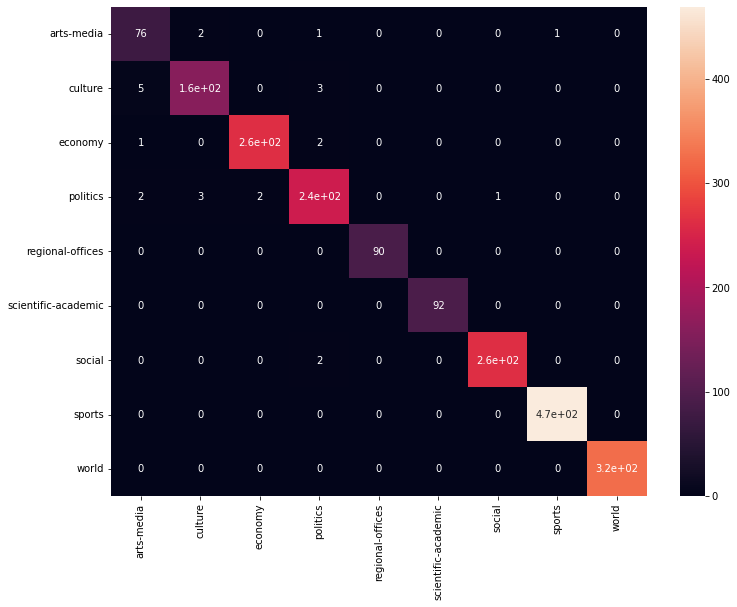

In [ ]:
# confusion matrix for last evaluation
c_mat = confusion_matrix(all_label, all_pred)
df_cm = pd.DataFrame(c_mat, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (12,9))
sn.heatmap(df_cm, annot=True)

## Testing Transformer

In [ ]:
# laod trained model from drive if you want to test it 
! gdown --id 1A4--gxG_O-XnKeagF0ktM-JndUrTutoH
model = torch.load('checkpoint.pth')


Downloading...
From: https://drive.google.com/uc?id=1A4--gxG_O-XnKeagF0ktM-JndUrTutoH
To: /content/checkpoint.pth
100% 473M/473M [00:07<00:00, 60.2MB/s]


In [ ]:
# test dataloader
test_dataset = NewsDataloader(trans_test_data, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
# loading pars bert and tokenizer
from transformers import AutoConfig, AutoTokenizer, AutoModel, TFAutoModel
# v3.0
model_name_or_path = "HooshvareLab/bert-fa-zwnj-base"
config = AutoConfig.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
device = 'cuda:0'
model = model.to(device)



with torch.no_grad():
  all_pred = []
  all_label = []
  for j, data in enumerate(test_dataloader):
    input_ids = data[0]["input_ids"].squeeze().to(device)
    attention_mask = data[0]["attention_mask"].squeeze().to(device)
    labels = data[1].to(device)
    feed_dict = {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }
    output = model(feed_dict)
    pred = output.argmax(dim=1, keepdim=True)
    all_label.extend(list(labels.cpu().numpy()))
    all_pred.extend(list(pred.view(-1).cpu().numpy()))


  f1_macro = f1_score(all_label, all_pred, average='macro')
  f1_micro = f1_score(all_label, all_pred, average='micro')
  accuracy = accuracy_score(all_label, all_pred)
  print(f'Test F1-macro {f1_macro}')
  print(f'Test F1-micro {f1_micro}')
  print(f'Test Accuracy {accuracy}')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Test F1-macro 0.9847801420357956
Test F1-micro 0.9875
Test Accuracy 0.9875


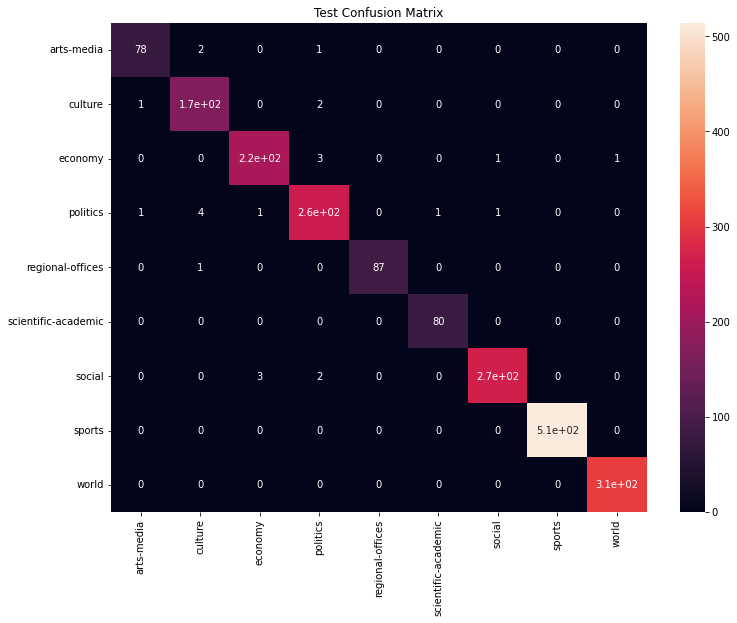

In [ ]:
# confusion matrix for test data
c_mat = confusion_matrix(all_label, all_pred)
df_cm = pd.DataFrame(c_mat, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (12,9))
plt.title('Test Confusion Matrix')
sn.heatmap(df_cm, annot=True)